In [5]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [20]:
actions = [
    '사랑',
    '솔직하다',
    '저울',
    '빵',
    '근육',
]

data = np.concatenate([
    np.load('dataset/seq_사랑_1667807586.npy'),
    np.load('dataset/seq_솔직하다_1667807586.npy'),
    np.load('dataset/seq_저울_1667807586.npy'),
    np.load('dataset/seq_빵_1667807586.npy'),
    np.load('dataset/seq_근육_1667807586.npy')
], axis=0)

data.shape

(2354, 30, 100)

In [21]:
x_data = data[:, :, :-1] # 마지막 값이 레이블 값이라 해당 값만 빼고 추출
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2354, 30, 99)
(2354,)


In [22]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2354, 5)

In [25]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2118, 30, 99) (2118, 5)
(236, 30, 99) (236, 5)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'), # LSTM 결과를 Dense에 담음
    Dense(len(actions), activation='softmax')  # 총 액션의 수인 6이 나옴
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-07 18:35:51.540681: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-07 18:35:51.541148: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 44,229
Trainable params: 44,229
Non-trainable params: 0
_________________________________________________________________


In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200


2022-11-07 18:36:07.841407: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-07 18:36:08.288269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 201.3466 - acc: 0.2531

2022-11-07 18:36:53.945512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.20339, saving model to models/model.h5
67/67 [==============================] - 47s 661ms/step - loss: 201.3466 - acc: 0.2531 - val_loss: 163.1002 - val_acc: 0.2034 - lr: 0.0010
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 131.7878 - acc: 0.2044
Epoch 2: val_acc improved from 0.20339 to 0.23729, saving model to models/model.h5
67/67 [==============================] - 43s 646ms/step - loss: 131.7878 - acc: 0.2044 - val_loss: 107.2366 - val_acc: 0.2373 - lr: 0.0010
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 57.3818 - acc: 0.2833
Epoch 3: val_acc improved from 0.23729 to 0.41949, saving model to models/model.h5
67/67 [==============================] - 44s 657ms/step - loss: 57.3818 - acc: 0.2833 - val_loss: 27.2212 - val_acc: 0.4195 - lr: 0.0010
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 20.5623 - acc: 0.3338
Epoch 4: val_acc did not improve from 0.41949
67/67 [===========

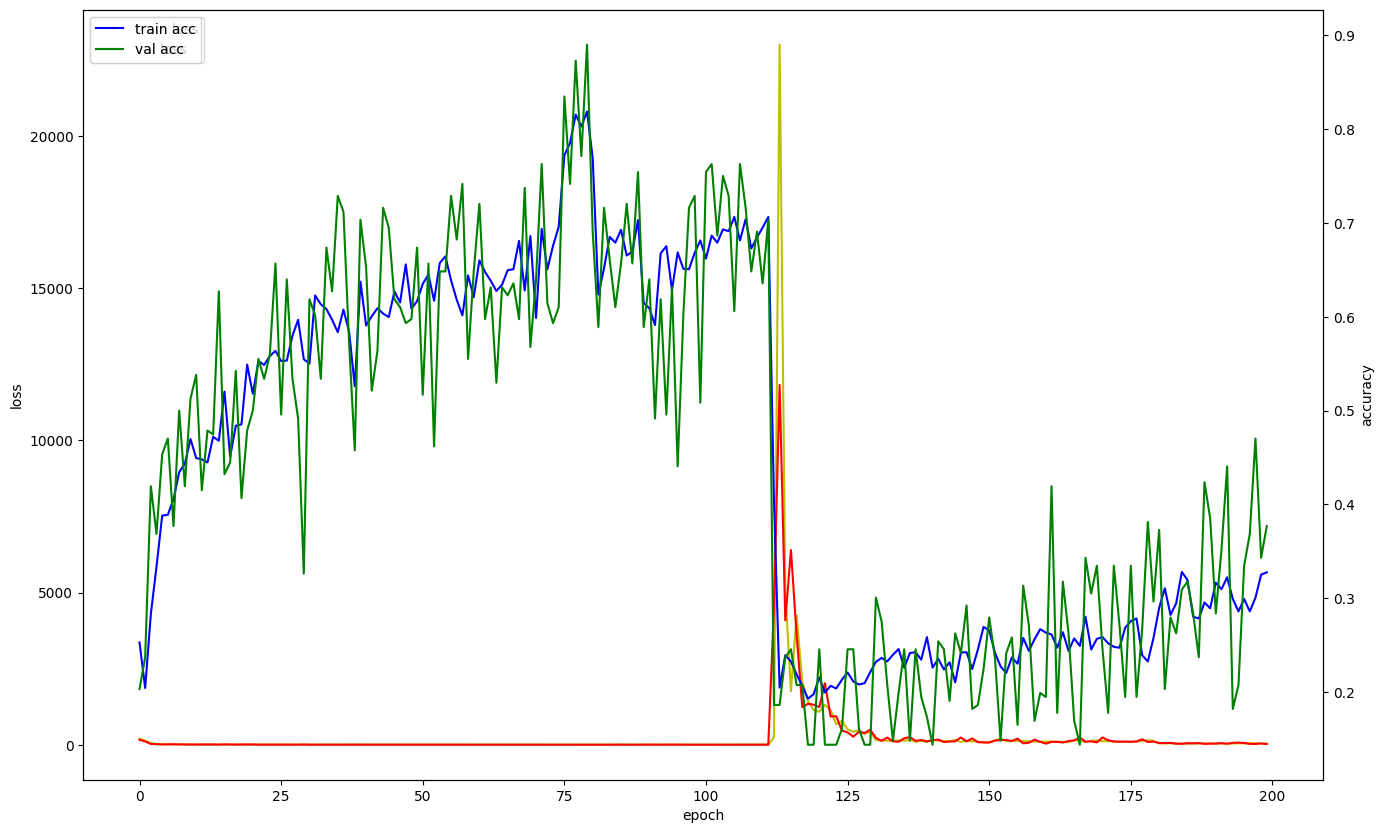

In [28]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [29]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

1/8 [==>...........................] - ETA: 1s

2022-11-08 11:02:41.829466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 109ms/step


array([[[171,   8],
        [  5,  52]],

       [[193,   5],
        [  3,  35]],

       [[186,   1],
        [  4,  45]],

       [[198,   4],
        [  7,  27]],

       [[170,   8],
        [  7,  51]]])